In [1]:
import pickle
import os
import numpy as np

from utils.funs import scores, scores_trace

from transformers import AutoModelForCausalLM

/opt/homebrew/Caskroom/miniconda/base/envs/attention-geometry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def getscoresOPT(d,l,h,dh,model):
    """
    Args:
        - d (int) : embeddding dimension.
        - l (int) : total number of layers
        - h (int) : number of heads.
        - dh (int) : embedding dimension per head.
        - model () : full model.

    Returns:
        - SList (numpy ndarray) : List of Symmetric (S) scores.
    """

    SList = np.zeros((l,h))
    
    # retrieve all block instances (each layer in the GPT architecture)
    layers = model.model.decoder.layers

    for i, layer in enumerate(layers):

        # access self-attention module within layer
        self_attention = layer.self_attn

        # access parameters of Conv1D
        Wq = self_attention.q_proj._parameters["weight"].T.view(d,h,dh).detach().numpy()
        Wk = self_attention.k_proj._parameters["weight"].T.view(d,h,dh).detach().numpy()

        for j in range(h):
            
            # compute symmetry scores
            SList[i,j] = scores_trace(Wq[:,j,:], Wk[:,j,:])

    return  SList

In [3]:
"""
- KEY (str): model name
- VALUES (list): [layers (int), 
                  embedding dim (int), 
                  heads (int), 
                  head dim (int), 
                  S scores, 
                  N scores]
"""

if os.path.isfile('../../_data/fig_scores/OPT-query-key.pkl'):
    with open('../../_data/fig_scores/OPT-query-key.pkl', 'rb') as file:
        models = pickle.load(file)
else: models = {}

In [21]:
dh = 64

'OPT 125m (l = 12, d = 768, h = 12 ; 125M parameters)'
l = 12
d = 768
h = d // dh
model = AutoModelForCausalLM.from_pretrained("facebook/opt-125m")
S= getscoresOPT(d,l,h,dh,model)
models['OPT-125m'] = [l,d,h,dh,S]

'OPT-350m (l = 24, d = 1024, h = 16 ; 350M parameters)'
l = 24
d = 1024
h = d // dh
model = AutoModelForCausalLM.from_pretrained("facebook/opt-350m")
S = getscoresOPT(d,l,h,dh,model)
models['OPT-350m'] = [l,d,h,dh,S]

'OPT-1.3b (l = 24, d = 2048, h = 32 ; 1.3B parameters)'
l = 24
d = 2048
h = d // dh
model = AutoModelForCausalLM.from_pretrained("facebook/opt-1.3b")
S = getscoresOPT(d,l,h,dh,model)
models['OPT-1.3b'] = [l,d,h,dh,S]

print('done')

'OPT-2.7b (l = 32, d = 1280, h = 32 ; 2.7B parameters)'
dh = 80
l = 32
d = 2560
h = d // dh
model = AutoModelForCausalLM.from_pretrained("facebook/opt-2.7b")
S = getscoresOPT(d,l,h,dh,model)
models['OPT-2.7b'] = [l,d,h,dh,S]

# print('done')

# 'OPT-6.7b (l = 32, d = 1280, h = 32 ; 6.7B parameters)'
# dh = 128
# l = 32
# d = 4096
# h = d // dh
# model = AutoModelForCausalLM.from_pretrained("facebook/opt-6.7b")
# S = getscoresOPT(d,l,h,dh,model)
# models['OPT-6.7b'] = [l,d,h,dh,S]

# print('done')

# 'OPT-13b (l = 32, d = 1280, h = 40 ; 13B parameters)'
# dh = 128
# l = 40
# d = 5120
# h = d // dh
# model = AutoModelForCausalLM.from_pretrained("facebook/opt-13b")
# S = getscoresOPT(d,l,h,dh,model)
# models['OPT-13b'] = [l,d,h,dh,S]

# print('done')

# 'OPT-30b (l = 32, d = 1280, h = 56 ; 30B parameters)'
# dh = 128
# l = 48
# d = 7168
# h = d // dh
# model = AutoModelForCausalLM.from_pretrained("facebook/opt-30b")
# S = getscoresOPT(d,l,h,dh,model)
# models['OPT-30b'] = [l,d,h,dh,S]

# print('done')

# 'OPT-66b (l = 32, d = 1280, h = 72 ; 66B parameters)'
# dh = 128
# l = 64
# d = 9216
# h = d // dh
# model = AutoModelForCausalLM.from_pretrained("facebook/opt-30b")
# S = getscoresOPT(d,l,h,dh,model)
# models['OPT-66b'] = [l,d,h,dh,S]

# print('done')

# 'OPT-175b (l = 32, d = 1280, h = 96 ; 175B parameters)'
# dh = 128
# l = 96
# d = 12288
# h = d // dh
# model = AutoModelForCausalLM.from_pretrained("facebook/opt-175b")
# S = getscoresOPT(d,l,h,dh,model)
# models['OPT-175b'] = [l,d,h,dh,S]

'save'
with open('../../_data/fig_scores/OPT-query-key.pkl', 'wb') as file:
    pickle.dump(models, file)

done


(0.0, 1.0)

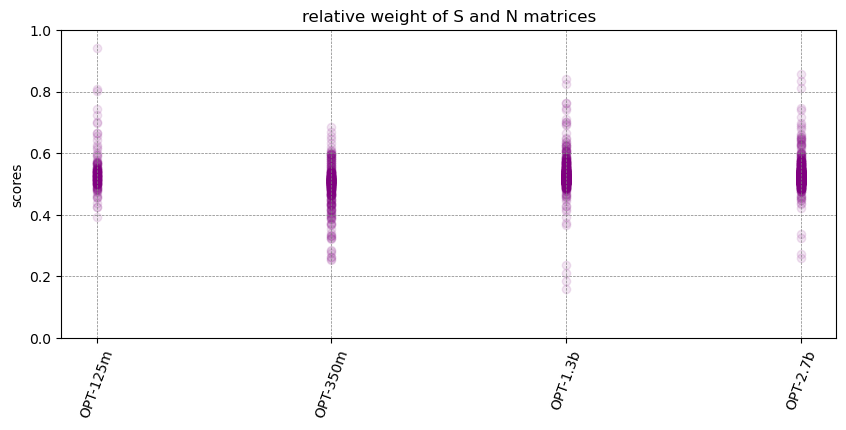

In [4]:
import matplotlib.pyplot as plt

with open('../../_data/fig_scores/OPT-query-key.pkl', 'rb') as file:
    models = pickle.load(file)

SList = [models[key][-1].flatten() for key in list(models.keys())]
# NList = [models[key][-1].flatten() for key in list(models.keys())]
names = list(models.keys())

plt.figure(figsize=(10,4))

for i, model in enumerate(SList):
    
    plt.scatter(i*np.ones(SList[i].size),(SList[i].flatten()),color='purple',alpha=.1)
    plt.scatter(i,(SList[i].flatten()).mean(),color='purple')
    
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.title('relative weight of S and N matrices')
plt.ylabel('scores')
plt.xticks(np.arange(len(names)),names)
plt.xticks(rotation=70)
plt.ylim(0,1)